# 利用 IQA 方法过滤低质量图片

本文将介绍利用 PaddleMIX 中 `paddlemix.datacopilot.ops.filter` 的 IQA 方法过滤数据集里 `低质量` 图片的方法。

IQA 即 Image Quality Assessment，图像质量评估方法，是通过对图像进行特性分析研究，然后评估出图像优劣，如图像失真、扭曲、模糊，以及图像的美学等方面的定量分析方法。

本文将介绍以下几个部分：

- PaddleMIX 的 IQA 方法
- PaddleMIX 的 Filter
- PaddleMIX 的 Tagger



## 1. PaddleMIX 的 IQA 方法

本文将引入两个 IQA 方法：

- ARNIQA: [ARNIQA: Learning Distortion Manifold for Image Quality Assessment](https://arxiv.org/abs/2310.14918v2)
- BRISQUE: [No-Reference Image Quality Assessment in the Spatial Domain](https://ieeexplore.ieee.org/document/6272356)



### 1.1 ARNIQA

ARNIQA 在文章 [ARNIQA: Learning Distortion Manifold for Image Quality Assessment](https://arxiv.org/abs/2310.14918v2) 中引入。

> ARNIQA 是一种用于图像质量评估（IQA）的自监督学习方法，全称为 "leArning distoRtion maNifold for Image Quality Assessment" 。它的核心目标是开发一种无需高质量参考图像就能测量图像质量的方法，与人类感知一致。ARNIQA 通过建模图像失真流形（distortion manifold）来获得质量表示，这是一种内在的方式。

PaddleMIX 中的 ARNIQA 模型在 `PaddleMIX/paddlemix/datacopilot/nn/arniqa` 目录中。

原模型使用 PyTorch 实现，这里通过 [X2Paddle](https://github.com/PaddlePaddle/X2Paddle) 将原模型转换为 Paddle 模型后使用。

ARNIQA 的结构大体可以分为：

- encoder
- regressor

两部分。

X2Paddle 的转换代码如下：

``` python

import pickle
from collections import OrderedDict

import numpy as np

import torch
import torchvision
from torch import nn
from transformers import GPT2Model, GPT2Tokenizer

import paddle
from iqa_arniqa import forward as paddle_forward
from iqa_arniqa_torch import forward as torch_forward

# Part 1. 构建原模型
# 构建 encoder
encoder = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
feat_dim = encoder.fc.in_features

print('-' * 20)
print(encoder)

encoder = nn.Sequential(*list(encoder.children())[:-1])

print('=' * 20)
print(encoder)

print(feat_dim)

# 加载参数：https://hf-mirror.com/chaofengc/IQA-PyTorch-Weights/blob/main/ARNIQA.pth
encoder_state_dict = torch.load('../dataset/ARNIQA/ARNIQA.pth',
                                weights_only=True)

# 参考 pyiqa 进行参数映射
cleaned_encoder_state_dict = OrderedDict()
for key, value in encoder_state_dict.items():
    # Remove the prefix
    if key.startswith("model."):
        new_key = key[6:]
        cleaned_encoder_state_dict[new_key] = value

encoder.load_state_dict(cleaned_encoder_state_dict)
encoder.eval()

# 构建 regressor：https://hf-mirror.com/chaofengc/IQA-PyTorch-Weights/blob/main/regressor_koniq10k.pth
regressor: nn.Module = torch.jit.load(
    '../dataset/ARNIQA/regressor_koniq10k.pth'
)  # Load regressor from torch.hub as JIT model
regressor.eval()

# regressor 是个线性模型
print('-' * 20)
print(regressor.biases)
print(regressor.weights)

# 模拟输入
input_data = np.random.rand(1, 3, 256, 256).astype('float32')

input_model = torch.tensor(input_data)
input_model_paddle = paddle.to_tensor(input_data)
input_model_resnet50 = paddle.to_tensor(input_data)

save_dir = "pd_model"
jit_type = "trace"

from x2paddle.convert import pytorch2paddle

# 转换 encoder
pytorch2paddle(encoder,
               save_dir,
               jit_type, [input_model],
               disable_feedback=True)

input_data_regressor = np.random.rand(1, 2048).astype('float32')
input_regressor = torch.tensor(input_data_regressor)
input_regressor_paddle = paddle.to_tensor(input_data_regressor)

save_dir = "pd_model_regressor"

# 转换 regressor
pytorch2paddle(regressor,
               save_dir,
               jit_type, [input_regressor],
               disable_feedback=True)

IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

default_mean = torch.Tensor(IMAGENET_DEFAULT_MEAN).view(1, 3, 1, 1)
default_std = torch.Tensor(IMAGENET_DEFAULT_STD).view(1, 3, 1, 1)

default_mean_paddle = paddle.to_tensor(IMAGENET_DEFAULT_MEAN).view([1, 3, 1, 1])
default_std_paddle = paddle.to_tensor(IMAGENET_DEFAULT_STD).view([1, 3, 1, 1])

torch_score = torch_forward(input_model, encoder, regressor, default_mean,
                            default_std, feat_dim)

# 查看原模型分数
print('-' * 20)
print('>>> torch score:', torch_score)

# Part 2. 加载转换后的模型
from pd_model.x2paddle_code import Sequential as encoder_paddle_model
from pd_model_regressor.x2paddle_code import TorchLinearRegression as regressor_paddle_model

paddle.disable_static()

encoder_paddle = encoder_paddle_model()
regressor_paddle = regressor_paddle_model()

encoder_paddle_params = paddle.load(r'./pd_model/model.pdparams')
encoder_paddle.set_dict(encoder_paddle_params, use_structured_name=True)
encoder_paddle.eval()

regressor_paddle_params = paddle.load(r'./pd_model_regressor/model.pdparams')
regressor_paddle.set_dict(regressor_paddle_params, use_structured_name=True)
regressor_paddle.eval()

paddle_score = paddle_forward(input_model_paddle, encoder_paddle,
                              regressor_paddle, default_mean_paddle,
                              default_std_paddle, feat_dim)

# 查看转换后计算的分数
print('-' * 20)
print('>>> paddle score:', paddle_score)

# 将 encoder 和 regressor 整合到一个 ARNIQA 模型中
from iqa_arniqa_model import ARNIQA

arniqa = ARNIQA(default_mean_paddle, default_std_paddle, feat_dim)
arniqa_score = arniqa(input_model_paddle)

# 查看整合后计算的分数
print('-' * 20)
print('>>> arniqa score:', arniqa_score)

# 保存整合后的模型
from os import path as osp

input_spec = paddle.static.InputSpec(shape=[-1, 3, -1, -1],
                                     name='x',
                                     dtype='float32')
static_model = paddle.jit.to_static(arniqa,
                                    input_spec=[input_spec],
                                    full_graph=True)
paddle.jit.save(static_model,
                osp.join('pd_model_arniqa', "inference_model/model"))

paddle.enable_static()
exe = paddle.static.Executor()
[prog, inputs, outputs] = paddle.static.load_inference_model(
    path_prefix="pd_model_arniqa/inference_model/model", executor=exe)
result = exe.run(prog, feed={inputs[0]: input_data}, fetch_list=outputs)
print('-' * 20)
print('>>> arniqa static score:', result)

# Part 3. 比对 pyiqa 中的 arniqa 模型所计算的分数
import pyiqa

iqa_metric = pyiqa.create_metric('arniqa')
score_nr = iqa_metric(input_model)

print('-' * 20)
print('>>> pyiqa score:', score_nr)


```

查看打印结果：

``` shell

--------------------
>>> torch score: tensor([0.4777], grad_fn=<AddBackward0>)
--------------------
>>> paddle score: Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [0.47766486])
--------------------
>>> arniqa score: Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [0.47766486])
I1222 06:34:13.690047   227 pir_interpreter.cc:1445] New Executor is Running ...
I1222 06:34:13.701393   227 pir_interpreter.cc:1471] pir interpreter is running by multi-thread mode ...
--------------------
>>> arniqa static score: [array([0.47766486], dtype=float32)]
--------------------
>>> pyiqa score: tensor([0.4777], device='cuda:0')


```

可以看到，转换后的模型精度可以对齐原模型。

这里将转换后的 encoder 与 regressor 分别放入 `PaddleMIX/paddlemix/datacopilot/nn/arniqa` 目录中。






### 1.2 在 PaddleMIX 中使用 ARNIQA

在 PaddleMIX 中可以直接调用 ARNIQA 模型，如：

``` python

import numpy as np
import paddle
from paddlemix.datacopilot.nn import ARNIQA

arniqa = ARNIQA()
input_data = np.random.rand(1, 3, 256, 256).astype('float32')
score = arniqa(paddle.to_tensor(input_data))
print(score)

```

结果为

``` shell

Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [0.41729081])

```

### 1.3 BRISQUE

BRISQUE 在文章 [No-Reference Image Quality Assessment in the Spatial Domain](https://ieeexplore.ieee.org/document/6272356) 中引入。

> BRISQUE（Blind/Referenceless Image Spatial Quality Evaluator）是一种无参考图像质量评估（NR-IQA）算法，由Mittal等人在2012年提出
。这种算法的核心思想是利用自然场景统计（NSS）特征来评估图像质量，而无需任何参考图像。BRISQUE 使用支持向量机（SVM）对提取的特征进行分类，从而预测图像的质量分数。

PaddleMIX 中的 BRISQUE 模型直接使用 [brisque](https://github.com/rehanguha/Brisque) 中所提供的接口。

示例如下：


``` python

from brisque import BRISQUE

obj = BRISQUE(url=False)
score_brisque = obj.score(np.squeeze(input_data).transpose([1, 2, 0]))
print('-' * 20)
print('>>> brisque score:', score_brisque)

```

可以得到结果：

``` shell

--------------------
>>> brisque score: 89.80066752516188

```

这里需要注意的是，[brisque](https://github.com/rehanguha/Brisque) 计算的结果越高，则图像质量越差，计算结果通常需要在 `[0, 100]` 之间。

这里为了与 ARNIQA 方法保持一致，需要对其结果进行 `[0, 100]` 之间的裁减并转换至 `[0, 1]` 之间，并且分数越高，则图像质量越好。

转换代码主要逻辑为：

``` python

def _score(model, img_path):
    img = Image.open(img_path)
    img = np.asarray(img)
    score = model.score(img=img)

    # clip score to [0, 100]
    score = max(0, score)
    score = min(100, score)

    # convert BRISQUE score [0, 100] to [0, 1], and higher is better
    score = (100 - score)/100
    return score

```

## 2. PaddleMIX 的 Filter

使用 Filter 可以过滤数据集中特定的 `低质量` 数据，这里的 `低质量` 如果针对图像数据，可以是模糊、扭曲的图像，如果针对文本，可以是长度过短、意义不明的文本，如果针对图像与文本对，可以是图像与文本匹配程度低等情况。

本文引入三个 Filter：

- iqa_arniqa，利用 ARNIQA 模型过滤低质量的图像。
- iqa_brisque，利用 BRISQUE 模型过滤低质量的图像。
- ensemble，根据数据集中已有的 `tagger`，如 ARNIQA 分数与 BRISQUE 分数，与各 `tagger` 的权重组合过滤数据。

其中 `iqa_arniqa` 与 `iqa_brisque` 针对图像数据进行过滤，`ensemble` 可以组合过滤数据。

### 2.1 过滤器 iqa_arniqa

过滤器 `iqa_arniqa` 在文件 `PaddleMIX/paddlemix/datacopilot/ops/filter/_iqa_arniqa.py` 中。

通过上文提到的 ARNIQA 模型对图像进行打分过滤，接口如下：

``` python
def iqa_arniqa(
    item: T, 
    min_score: float = 0., 
    max_score: float = 1., 
    key: str = 'image',
    ) -> bool:
```

其中：

- item，为输入项
- min_score，为过滤所需的最小分数
- max_score，为过滤所需的最大分数
- key，为 item 中图像的键

返回为 `bool` 值，如果计算得到的分数在 `min_score` 与 `max_score` 之间，则返回 `True` ，否则返回 `False` 。

另外，如果 `item` 中没有 `key` (如 `image`) 字段，则默认返回 `True`，即保留此数据。

这里抽取 llava_v1_5_mix665k 数据中的 10 张图片用于演示接口的使用。

In [1]:
from functools import partial
import numpy as np
import paddle
from paddlemix.datacopilot.core import MMDataset
from paddlemix.datacopilot.ops.filter import iqa_arniqa

# 这里的 `llava_tmp_10.json` 是从 `llava_v1_5_mix665k.json` 中抽取的 10 条记录
# 其中的图片可以从 https://hf-mirror.com/datasets/adamo1139/llava-instruct-150k-with-images 下载
path = 'llava_tmp_10.json'
dataset = MMDataset.from_json(path)

fn = partial(iqa_arniqa, min_score=0.6)
new_dataset = dataset.filter(fn, max_workers=1)


/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:686: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2024-12-22 16:06:43,819] [ WARNING] - Detected that datasets module was imported before paddlenlp. This may cause PaddleNLP datasets to be unavalible in intranet. Please imp

import module error: fast_ln
import module error: fused_ln
Warning, FusedLn module is not available, use LayerNorm instead.
Warning, FusedLn module is not available, use LayerNorm instead.
modeling_internlm2 has_flash_attn is True.
modeling_intern_vit has_flash_attn is True.
paddlenlp is not installed.


100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


In [2]:
len(dataset), len(new_dataset)

(10, 9)

In [3]:
raw_imgs = set()
new_imgs = set()
for i in dataset:
    raw_imgs.add(i['image'])
for i in new_dataset:
    new_imgs.add(i['image'])

print(raw_imgs - new_imgs)

{'train2017/000000494884.jpg'}


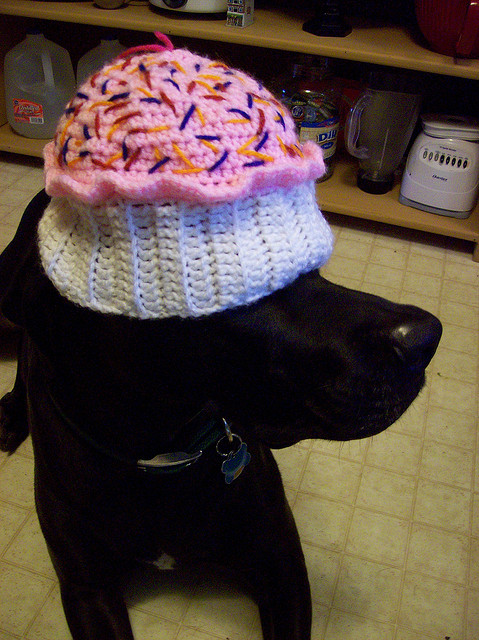

In [4]:
from PIL import Image

img = Image.open('train2017/000000494884.jpg')
img.show()


可以看到，通过 `iqa_arniqa` 并设置最小分数 `min_score=0.6` ，过滤后，数据集中过滤掉了上面的这张图片，数据集由 `10` 个过滤为 `9` 个。

### 2.2 过滤器 iqa_brisque

过滤器 `iqa_brisque` 在文件 `PaddleMIX/paddlemix/datacopilot/ops/filter/_iqa_brisque.py` 中。

通过上文提到的 BRISQUE 模型对图像进行打分过滤，接口如下：

``` python
def iqa_brisque(
    item: T, 
    min_score: float = 0., 
    max_score: float = 1., 
    key: str = 'image',
    ) -> bool:
```

此接口的参数与 `iqa_arniqa` 相同，这里同样使用上面从 llava_v1_5_mix665k 抽取到的 10 张图片用于演示接口的使用。

In [5]:
from functools import partial
import numpy as np
import paddle
from paddlemix.datacopilot.core import MMDataset
from paddlemix.datacopilot.ops.filter import iqa_brisque

path = 'llava_tmp_10.json'
dataset = MMDataset.from_json(path)

fn = partial(iqa_brisque, min_score=0.7)
new_dataset = dataset.filter(fn, max_workers=1)


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


In [6]:
len(dataset), len(new_dataset)

(10, 9)

In [7]:
raw_imgs = set()
new_imgs = set()
for i in dataset:
    raw_imgs.add(i['image'])
for i in new_dataset:
    new_imgs.add(i['image'])

print(raw_imgs - new_imgs)

{'train2017/000000504730.jpg'}


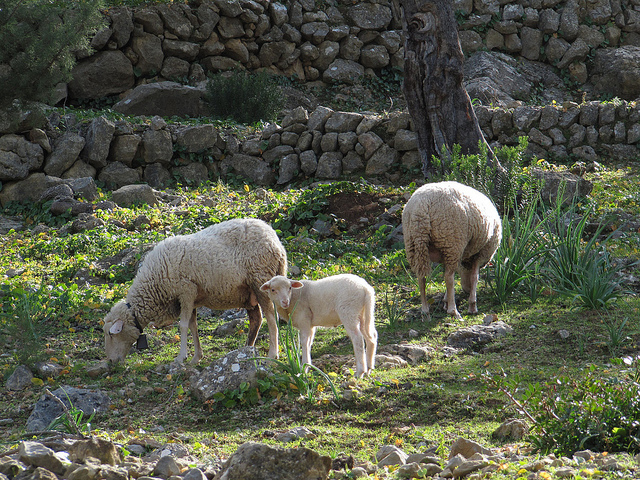

In [8]:
from PIL import Image

img = Image.open('train2017/000000504730.jpg')
img.show()


可以看到，通过 `iqa_brisque` 并设置最小分数 `min_score=0.7` ，过滤后，数据集中过滤掉了上面的这张图片，数据集由 `10` 个过滤为 `9` 个。

通过以上演示可以看到，`iqa_arniqa` 与 `iqa_brisque` 方法接口的使用是一样的，但是结果不一样，这对分析数据集的质量提供了多种角度的考虑方式。

另外，`ensemble` 过滤器可已结合后文提到的 `Tagger` 一同使用，后文会详细介绍 `ensemble` 过滤器的使用。

## 3. PaddleMIX 的 Tagger

通过 Filter 可以过滤掉数据集中的特定数据，但是，当数据集很大的时候，我们需要一种手段先对数据集进行分析评估，然后再对数据集进行过滤采样。

由此，这里引入 `Tagger` ，即数据标注，可以先通过 `Tagger` 对数据集中的数据进行打分，将分数嵌入到数据集中，然后再通过宏观分析，如分数的均值、方差等，决定过滤掉哪些数据，如分数低于均值的数据。

`Tagger` 的接口类位于 `PaddleMIX/paddlemix/datacopilot/ops/filter/_tagger.py` 中：

``` python
class Tagger(object):

    def tag(self, item: T) -> T:
        item[self.key()] = self.score(item)
        return item

    def key(self) -> str:
        raise NotImplementedError

    def score(self, item: T) -> float:
        raise NotImplementedError

    def __call__(self, item: T) -> T:
        return self.tag(item)
```

主要定义了：

- `tag` 方法，用于返回打完分数的 item
- `key` 方法，需要子类实现，用于区分不同的 Tagger
- `score` 方法，用于对 item 进行打分
- `__call__` 方法，用于直接调用

> 说明：由于 Tagger 与 Filter 作用相近却不同，因此，暂未将两者整合到一起。

本文引入两个 Tagger：

- ARNIQATagger，利用 ARNIQA 模型对数据进行打分
- BRISQUETagger，利用 BRISQUE 模型对数据进行打分



### 3.1 ARNIQATagger

`ARNIQATagger` 在文件 `PaddleMIX/paddlemix/datacopilot/ops/filter/_iqa_arniqa.py` 中。

可以直接使用 `tag_arniqa` 对数据集打标。


In [9]:
from paddlemix.datacopilot.ops.filter import tag_arniqa
tag_dataset = dataset.map(tag_arniqa) 

100%|██████████| 10/10 [00:01<00:00,  8.90it/s]


In [10]:
# 查看嵌入的字段
print(tag_dataset[0].keys())

dict_keys(['id', 'image', 'conversations', '__tag_arniqa'])


In [11]:
# 查看嵌入的分数
for d in tag_dataset:
    print(d['__tag_arniqa'])

0.64162034
0.68887085
0.7187992
0.674319
0.6732159
0.74029523
0.59954
0.69299656
0.68343085
0.7909594


### 3.2 BRISQUETagger

`BRISQUETagger` 在文件 `PaddleMIX/paddlemix/datacopilot/ops/filter/_iqa_brisque.py` 中。

可以直接使用 `tag_brisque` 对数据集打标。


In [12]:
from paddlemix.datacopilot.ops.filter import tag_brisque
tag_dataset = tag_dataset.map(tag_brisque) 

100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


In [13]:
# 查看嵌入的字段
print(tag_dataset[0].keys())

dict_keys(['id', 'image', 'conversations', '__tag_arniqa', '__tag_brisque'])


In [14]:
# 查看嵌入的分数
for d in tag_dataset:
    print(d['__tag_arniqa'], d['__tag_brisque'])

0.64162034 0.8593748951089336
0.68887085 0.7037187648966691
0.7187992 0.6889763363188675
0.674319 0.7145388288641314
0.6732159 0.8589167538506266
0.74029523 0.8761964461298001
0.59954 0.9422470606237429
0.69299656 1.0
0.68343085 0.7551577195601546
0.7909594 1.0


可以看到，通过以上 `Tagger` ，已经将 ARNIQA 与 BRISQUE 分数嵌入到数据集中，我们便可以分析数据集的分布情况。

In [15]:
score_arniqa = [d['__tag_arniqa'] for d in tag_dataset]
score_brisque = [d['__tag_brisque'] for d in tag_dataset]

In [16]:
import scipy
scipy.stats.describe(score_arniqa)

DescribeResult(nobs=10, minmax=(0.59954, 0.7909594), mean=0.6904047, variance=0.002739419901950492, skewness=0.23519346591831602, kurtosis=0.011748301514658444)

In [17]:
scipy.stats.describe(score_brisque)

DescribeResult(nobs=10, minmax=(0.6889763363188675, 1.0), mean=0.8399126805352927, variance=0.014224137561604368, skewness=0.05486848219025151, kurtosis=-1.4214439254874505)

通过上文提到的 `ensemble` 过滤器，结合不同的权重，可以过滤出不同数量的采样数据集。

`ensemble` 过滤器的接口如下：

``` python

def ensemble(
    item: T, 
    taggers: Sequence[Tagger | str],
    weights: Sequence[float],
    min_score: float = 0., 
    max_score: float = 1., 
    ) -> bool:

```

其中，

- item，表示需要过滤的对象
- taggers，可以是 Tagger 或者 str，表示 item 可供过滤的项
- weights，表示各个 Tagger 的权重
- min_score，过滤的最小分数
- max_score，过滤的最大分数

In [18]:
from paddlemix.datacopilot.ops.filter import ensemble
ensemble_fn = partial(ensemble, taggers=[tag_arniqa, tag_brisque], weights=[0.2, 0.8], min_score=0.7)
new_dataset = tag_dataset.filter(ensemble_fn, max_workers=3)
len(new_dataset)

100%|██████████| 10/10 [00:00<00:00, 6476.69it/s]


9

In [19]:
ensemble_fn = partial(ensemble, taggers=[tag_arniqa, tag_brisque], weights=[0.3, 0.7], min_score=0.7)
new_dataset = tag_dataset.filter(ensemble_fn, max_workers=3)
len(new_dataset)

100%|██████████| 10/10 [00:00<00:00, 7033.88it/s]


8

In [20]:
ensemble_fn = partial(ensemble, taggers=[tag_arniqa, tag_brisque], weights=[0.8, 0.2], min_score=0.7)
new_dataset = tag_dataset.filter(ensemble_fn, max_workers=3)
len(new_dataset)

100%|██████████| 10/10 [00:00<00:00, 8298.98it/s]


5

可以看到，通过设定不同的权重，可以控制采样的数据量大小。基于此可以分析不同质量的数据集对最终模型的训练结果有何影响。

## 总结

本文介绍了 PaddleMIX 中引入的 Filter 过滤器与 Tagger 标注器的使用方法。重点介绍了 ARNIQA 模型与 BRISQUE 模型的使用。

用户可以通过使用 Filter 过滤掉数据集中低质量的数据，并可以结合 Tagger 与 `ensemble` 过滤器综合考量数据集中的不同参考点。

由此，为提供高质量数据集，并分析数据集对模型训练的结果有何影响提供了参考。

In [ ]:
# paddlemix/datacopilot/example/iqa_filter/llava_tmp_10.json

items = [{"id": "000000323950", "image": "train2017/000000323950.jpg", "conversations": [{"from": "human", "value": "<image>\nIs the airplane parked on a runway or a tarmac?"}, {"from": "gpt", "value": "The airplane is parked on the tarmac."}, {"from": "human", "value": "What type of airplane is it?"}, {"from": "gpt", "value": "It is a large commercial airplane."}, {"from": "human", "value": "What kind of vehicles are around the airplane?"}, {"from": "gpt", "value": "There are several airport utility vehicles surrounding the airplane. These are likely maintenance, fueling, or luggage handling trucks that are performing various tasks associated with the airplane's servicing and preparation for a flight."}, {"from": "human", "value": "What is the purpose of a tarmac in an airport?"}, {"from": "gpt", "value": "The term \"tarmac\" refers to the area within an airport designated for aircraft parking, loading/unloading of passengers, cargo, and luggage, refueling, and various other ground services. Tarmac is short for \"tarmacadam,\" which is a type of material used to pave surfaces like roads or other heavy-duty areas. However, modern airport tarmacs are often made of concrete or other materials designed to withstand the weight and movement of large aircraft.\n\nIn an airport context, the tarmac serves as a critical operational area where airplanes can be parked and receive essential services before or after flights. It enables a safe and organized process for airplane maintenance and servicing, boarding and deboarding of passengers, and efficient handling of cargo and luggage. Airport utility vehicles and personnel operate on the tarmac to perform various tasks necessary for flights' smooth operation, which ultimately ensures a safe and well-coordinated airport environment.\n\nIn summary, the tarmac is an essential area within airports that allows for organized and efficient ground handling of aircraft, providing support for all aspects of their pre- and post-flight operations, including passenger boarding, cargo and luggage handling, and airplane maintenance and servicing."}]}, {"id": "000000161156", "image": "train2017/000000161156.jpg", "conversations": [{"from": "human", "value": "<image>\nWhat type of fruit trees are in the image?"}, {"from": "gpt", "value": "The image features a row of orange trees."}, {"from": "human", "value": "What is the condition of the oranges on the trees?"}, {"from": "gpt", "value": "The oranges on the trees are ripe and ready to pick."}, {"from": "human", "value": "Where are the orange trees located?"}, {"from": "gpt", "value": "The orange trees are situated in an orchard farm, alongside a dirt road."}, {"from": "human", "value": "Is the orchard in a forest?"}, {"from": "gpt", "value": "No, the image shows an orchard of orange trees, not a forest. Orchards are typically cultivated areas specifically designated for growing fruit trees, whereas forests are naturally occurring ecosystems with a diverse range of tree species and other vegetation."}, {"from": "human", "value": "What is the significance of having an orchard and how do they benefit the environment?"}, {"from": "gpt", "value": "Orchards play an essential role in agriculture and have several environmental benefits. Some of these benefits include:\n\n1. Biodiversity and wildlife habitat: Orchards consisting of various fruit tree species can provide diverse habitats for many types of wildlife, including insects, birds, and small mammals. These animals can find shelter, food, and nesting sites among the trees, helping maintain a balanced ecosystem.\n\n2. Carbon sequestration: Like all trees, fruit trees absorb carbon dioxide from the atmosphere and convert it into biomass through the process of photosynthesis. In this way, orchards contribute to reducing greenhouse gas concentrations and mitigating the effects of climate change.\n\n3. Soil health: Fruit tree roots help retain soil structure and prevent erosion, especially in hilly or sloping areas. Also, fallen leaves, fruits, and organic matter from the trees decompose and enrich the soil with nutrients, fostering a healthy growing medium for both the trees and other plants.\n\n4. Pollination: Many fruit trees require pollinators, such as bees, butterflies, and other insects, to produce fruit. Orchards provide a rich source of nectar and pollen, attracting and sustaining pollinator populations, which in turn benefit the surrounding environment by facilitating the reproduction of many flowering plants.\n\n5. Local food production: Orchards produce a variety of fruits for human consumption. By growing food locally, orchards can help reduce the environmental footprint associated with long-distance transportation of produce and support local economies.\n\nIn conclusion, orchards contribute to the environment by supporting biodiversity, sequestering carbon, improving soil health, sustaining pollinator populations, and fostering local food production. The image of the row of orange trees in the orchard farm is an example of a cultivated area that is not only a source of delicious and nutritious fruit but also provides various environmental benefits."}]}, {"id": "000000504730", "image": "train2017/000000504730.jpg", "conversations": [{"from": "human", "value": "How many sheep and lambs are visible in the image?\n<image>"}, {"from": "gpt", "value": "In the image, there are three sheep visible, which include two adult sheep and one baby lamb."}, {"from": "human", "value": "What are the sheep doing in the image?"}, {"from": "gpt", "value": "The sheep in the image are standing and grazing in a field, with two adult sheep eating grass and the baby lamb standing beside them."}, {"from": "human", "value": "What is the landscape like in the image?"}, {"from": "gpt", "value": "The landscape in the image consists of a lush green field with grass and rocks scattered around. There are also rock walls in the background."}, {"from": "human", "value": "Is the lamb standing next to one or both adult sheep?"}, {"from": "gpt", "value": "The lamb is standing next to one of the bigger adult sheep while the sheep is eating grass."}, {"from": "human", "value": "What kind of environment do sheep generally prefer?"}, {"from": "gpt", "value": "Sheep generally prefer environments with ample grass and vegetation for grazing, as they are herbivorous animals that primarily feed on grass, herbs, and other plant materials. They thrive in pastures, meadows, and grasslands, which provide them with their preferred food sources and room for roaming.\n\nAdditionally, sheep tend to do well in environments with moderate climates, as their thick coats of wool help insulate them from cold temperatures, while their ability to dissipate heat is somewhat limited. Thus, they may struggle in extremely hot or cold conditions. Sheep also prefer environments with natural features like rocks, trees, and bushes, which can provide shelter from harsh weather conditions and predators.\n\nIn the image, the lush green field with grass and rocks, as well as the rock walls in the background, provide an ideal environment for the sheep and the baby lamb to graze, roam, and find shelter."}]}, {"id": "000000178859", "image": "train2017/000000178859.jpg", "conversations": [{"from": "human", "value": "<image>\nWhat type of animals are in the image?"}, {"from": "gpt", "value": "There are horses in the image."}, {"from": "human", "value": "What is the terrain like where the horses are standing?"}, {"from": "gpt", "value": "The horses are standing in a grassy area beside a small rock wall."}, {"from": "human", "value": "Are the horses near any body of water or mountains?"}, {"from": "gpt", "value": "Yes, the horses are in a rock-walled pasture by a lake in the mountains."}, {"from": "human", "value": "How many horses are visible in the image?"}, {"from": "gpt", "value": "There are a couple of horses visible in the image."}, {"from": "human", "value": "What could be the purpose of the rock wall near the horses?"}, {"from": "gpt", "value": "The rock wall near the horses may serve a few purposes. One possible purpose is to act as a boundary or enclosure to keep the horses confined within the pasture area, ensuring they don't wander too far and can be easily managed by their owners. The wall can also provide some protection from predators and mark the division between different areas of the terrain.\n\nAnother reason for the presence of the wall could be historical or cultural. In many rural settings, stone walls were traditionally built to divide land for farming or livestock purposes. Over time, these walls may continue to be maintained or restored as part of the area's history or heritage, adding character to the landscape.\n\nLastly, the rock wall might be a natural feature of the environment or built for erosion control, particularly if the pasture is close to the lake or in a mountainous area with potential for land degradation. In this case, it would help maintain the integrity of the surrounding terrain and prevent soil erosion, preserving the pasture for the horses to graze in."}]}, {"id": "000000401944", "image": "train2017/000000401944.jpg", "conversations": [{"from": "human", "value": "What type of meal is shown in the image?\n<image>"}, {"from": "gpt", "value": "The image features a vegetarian meal consisting of a bowl of soup with noodles, vegetables, and chili sauce. The dish appears to be an Asian noodle soup, with a dollop of bright red chili paste on the side."}, {"from": "human", "value": "Is the dish served on a plate or in a bowl?"}, {"from": "gpt", "value": "The dish is served in a bowl."}, {"from": "human", "value": "Are there any utensils visible in the image?"}, {"from": "gpt", "value": "Yes, there is a spoon visible in the image."}, {"from": "human", "value": "What are the main ingredients of the soup?"}, {"from": "gpt", "value": "The main ingredients of the soup are pasta or noodles, vegetables, a sauce, and bright red chili paste."}, {"from": "human", "value": "Is this dish typically a light meal or a main course?"}, {"from": "gpt", "value": "An Asian noodle soup with vegetables and chili paste can be served as either a light meal or a main course, depending on the portion size and the number of additional ingredients such as protein sources (e.g., tofu or tempeh in a vegetarian dish) and accompaniments (e.g., rice or additional side dishes). In general, noodle soups are versatile dishes that can be tailored to individual preferences and dietary requirements, making them suitable for a variety of meal settings."}]}, {"id": "000000101979", "image": "train2017/000000101979.jpg", "conversations": [{"from": "human", "value": "<image>\nHow many people are there in the image?"}, {"from": "gpt", "value": "There are two people in the image."}, {"from": "human", "value": "Are the two people skiing or standing?"}, {"from": "gpt", "value": "The two people are skiing on a cross-country slope, traveling across the snowy field while holding ski poles."}, {"from": "human", "value": "What kind of landscape surrounds the skiers?"}, {"from": "gpt", "value": "The skiers are surrounded by a frozen landscape, which includes a snowy field, snow-covered slopes, and a mountain in the background."}, {"from": "human", "value": "What type of skiing are the two people engaged in?"}, {"from": "gpt", "value": "The two people are engaged in cross-country skiing, as they are traveling across a snowy field with ski poles."}, {"from": "human", "value": "What can you tell about the snow conditions in the image?"}, {"from": "gpt", "value": "The image shows significant snow cover on the slopes, field, and mountain, indicating that the area has experienced a good amount of snowfall. The presence of snow in the landscape makes it ideal for winter sports such as cross-country skiing. The snow appears to be sufficiently packed to provide a suitable skiing surface for cross-country skiers, allowing them to glide across the field smoothly."}]}, {"id": "000000494884", "image": "train2017/000000494884.jpg", "conversations": [{"from": "human", "value": "<image>\nWhat kind of hat is the black dog wearing on its head?"}, {"from": "gpt", "value": "The black dog is wearing a crocheted hat that looks like a cupcake with pink frosting and sprinkles on its head."}, {"from": "human", "value": "Is the dog wearing only one hat, or are there two hats involved?"}, {"from": "gpt", "value": "The dog is wearing two hats on its head."}, {"from": "human", "value": "What is the dog doing and where is it located in the image?"}, {"from": "gpt", "value": "The black dog is laying on the kitchen floor, wearing two hats on its head."}, {"from": "human", "value": "What effect does the cupcake hat have on the dog's vision?"}, {"from": "gpt", "value": "The cupcake hat is positioned over the dog's eyes, obstructing its vision."}, {"from": "human", "value": "Can you describe the dog's size and any other notable features?"}, {"from": "gpt", "value": "The dog is a large black dog, with the most notable feature being the two hats it is wearing\u2014one of them being a crocheted cupcake hat with pink frosting and sprinkles. The dog is laying down on the kitchen floor, with the cupcake hat obstructing its vision, creating a cute and amusing scene."}]}, {"id": "000000120127", "image": "train2017/000000120127.jpg", "conversations": [{"from": "human", "value": "<image>\nWhat types of fruits are in the bowl?"}, {"from": "gpt", "value": "The bowl contains oranges and bananas."}, {"from": "human", "value": "How many bananas are in the bowl?"}, {"from": "gpt", "value": "There are two bananas in the bowl."}, {"from": "human", "value": "Where is the bowl of fruits located?"}, {"from": "gpt", "value": "The bowl of fruits is sitting on a kitchen counter."}, {"from": "human", "value": "What is the lighting condition in the image?"}, {"from": "gpt", "value": "The lighting condition in the image is bright, with sunlight shining on the fruit bowl, illuminating the oranges and bananas."}, {"from": "human", "value": "Is the bowl moderately filled or full of fruits?"}, {"from": "gpt", "value": "The bowl is full of fruits, with multiple oranges and two bananas heaped inside."}]}, {"id": "000000064933", "image": "train2017/000000064933.jpg", "conversations": [{"from": "human", "value": "<image>\nWhat is the woman doing in the image?"}, {"from": "gpt", "value": "The woman in the image is playing tennis, standing on a tennis court, and about to hit a tennis ball with her racket."}, {"from": "human", "value": "How many images are there of the woman with the tennis racket?"}, {"from": "gpt", "value": "There is a single image that features four photos of the woman in different poses with a tennis racket."}, {"from": "human", "value": "Is the woman standing in the field or on the tennis court?"}, {"from": "gpt", "value": "The woman is standing on a tennis court while playing with a tennis ball."}, {"from": "human", "value": "What is the woman using to play tennis?"}, {"from": "gpt", "value": "The woman is using a tennis racket to play tennis."}, {"from": "human", "value": "Can you provide a brief overview of the sport of tennis?"}, {"from": "gpt", "value": "Tennis is a popular global sport that is played between either two individuals (singles) or two teams of two players each (doubles). Originating in England during the late 19th century, the sport is now enjoyed by millions of people worldwide, both recreationally and professionally.\n\nThe objective of the game is to strike a hollow rubber ball, known as a tennis ball, over a net that divides the tennis court into two equal halves. Players use a tennis racket to hit the ball, aiming to make it bounce within the opponent's court area, with the goal of winning points. Players score points when their opponent is unable to return the ball within the designated boundaries or commits a playing error.\n\nTennis courts can be indoor or outdoor and come in different surfaces, such as grass, clay, or hard court. The court dimensions, markings, and the net height are standardized by the International Tennis Federation (ITF), which governs the sport's rules and regulations.\n\nA tennis match consists of sets, and each set consists of games. In a game, one player serves the ball, attempting to win points, while the other player receives the serve and tries to return it successfully. To win a set, a player must reach a specific number of games won, with a two-game advantage over the opponent. The number of sets required to win a match varies depending on the competition or tournament.\n\nTennis has four major annual tournaments known as the Grand Slam events, the Australian Open, the French Open, Wimbledon, and the US Open, each played on different surfaces. These prestigious tournaments attract top players from around the world and captivate tennis fans globally."}]}, {"id": "000000250474", "image": "train2017/000000250474.jpg", "conversations": [{"from": "human", "value": "What is the person doing in the image?\n<image>"}, {"from": "gpt", "value": "The person in the image is standing up and playing a video game on Wii, while watching the TV screen closely."}, {"from": "human", "value": "What color is the shirt that the man is wearing?"}, {"from": "gpt", "value": "The man is wearing a burnt orange shirt."}, {"from": "human", "value": "What gaming system is the person using?"}, {"from": "gpt", "value": "The person is using a Wii gaming system."}, {"from": "human", "value": "What are some typical activities while playing Wii?"}, {"from": "gpt", "value": "Playing Wii is a highly interactive gaming experience that involves physical movements and various gestures from the player. Some typical activities while playing Wii games include:\n\n1. Sports: Wii Sports is a popular game that simulates various sports like tennis, baseball, golf, bowling, and boxing. Players use the Wii Remote to mimic real-life actions as they swing a tennis racket or throw a baseball, for example.\n\n2. Dancing and Exercise: With games like Just Dance and Wii Fit, players can participate in dance challenges or fitness activities. These games often require players to move their bodies in sync with on-screen prompts or music.\n\n3. Adventure and Role-Playing Games: Players can become immersed in virtual worlds and complete diverse missions, solve puzzles, or fight enemies in games like The Legend of Zelda or Super Mario Galaxy. Wii Remotes are used to control character movement, interact with the environment, or perform in-game actions.\n\n4. Racing and Driving Games: Games like Mario Kart Wii combine the thrill of racing with unique game elements. Players hold the Wii Remote like a steering wheel and tilt it to control their vehicle's movement.\n\n5. Party and Family Games: Wii offers a variety of multiplayer games that cater to all age groups, such as Wii Party or Mario Party. These games feature a collection of mini-games that encourage friendly competition or teamwork among players.\n\nIn summary, Wii games cover a wide range of activities, allowing players to engage in sports simulations, dancing, exercise, adventure, racing, or family-friendly party games. While playing Wii, gamers use the Wii Remote and physical movements to control gameplay, making the experience highly interactive and immersive."}]}]

dataset = MMDataset(items)